In [1]:
!pip install -qq -U diffusers transformers gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00

In [2]:
# Setup
import os

%cd /content
!git clone https://github.com/shreyas-bk/U-2-Net
%cd /content/U-2-Net
!mkdir images
!mkdir results

image_dir = os.path.join(os.getcwd(), 'images')
results_dir = os.path.join(os.getcwd(), 'results')
image_files = os.listdir(image_dir)

/content
Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (520/520), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 520 (delta 237), reused 510 (delta 236), pack-reused 0
Receiving objects: 100% (520/520), 12.38 MiB | 11.22 MiB/s, done.
Resolving deltas: 100% (237/237), done.
/content/U-2-Net


In [3]:
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import PIL
from PIL import Image as Img
import cv2
from google.colab.patches import cv2_imshow
from diffusers import StableDiffusionInpaintPipeline
import torch
import requests
from io import BytesIO
import gradio as gr

In [4]:
def get_image(url):
    # Retrieve the image from the provided URL
    response = requests.get(url)
    return Img.open(BytesIO(response.content))

def resize_image(image, max_size):
    # Resize the image while maintaining aspect ratio
    image.thumbnail((max_size, max_size), Img.ANTIALIAS)
    return image

def extend_image(image, width=512, height=512):
    # Resize and center images while leaving enough space for the background
    extended_image = Img.new("RGBA", (width, height), (255, 255, 255, 0))
    x_offset = (width - image.width) // 2
    y_offset = (height - image.height) // 2
    extended_image.paste(image, (x_offset, y_offset), mask=image.split()[3])
    return extended_image

def extend_mask(mask_image, width=512, height=512):
    # Extend the mask image to match the size of the extended image
    extended_image = Img.new("L", (width, height), 255)
    extended_image.paste(mask_image, ((width - mask_image.width) // 2, (height - mask_image.height) // 2))
    return extended_image

def display_images(images):
    # Display a list of images horizontally
    num_images = len(images)
    total_width = sum(image.width for image in images)
    max_height = max(image.height for image in images)
    new_image = Img.new('RGBA', (total_width, max_height))
    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width
    new_image.show()

def download_image(image, file_name):
    # Save the image with the specified file name
    image.save(file_name)
    files.download(file_name)

def clear_directory(directory):
    # Remove all files from the specified directory
    files = os.listdir(directory)
    for file in files:
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

def diffusion_setup():
    # Set up the stable diffusion inpainting pipeline
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "stabilityai/stable-diffusion-2-inpainting"
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_path,
        torch_dtype=torch.float16 if device.type == "cuda" else torch.float32,
    ).to(device)
    return pipe

In [ ]:
# Upload images in '.jpg' or '.png' format
# Alternatively, you can upload files via the file explorer on Google Colab

%cd /content/U-2-Net/images
uploaded = files.upload()
%cd /content/U-2-Net

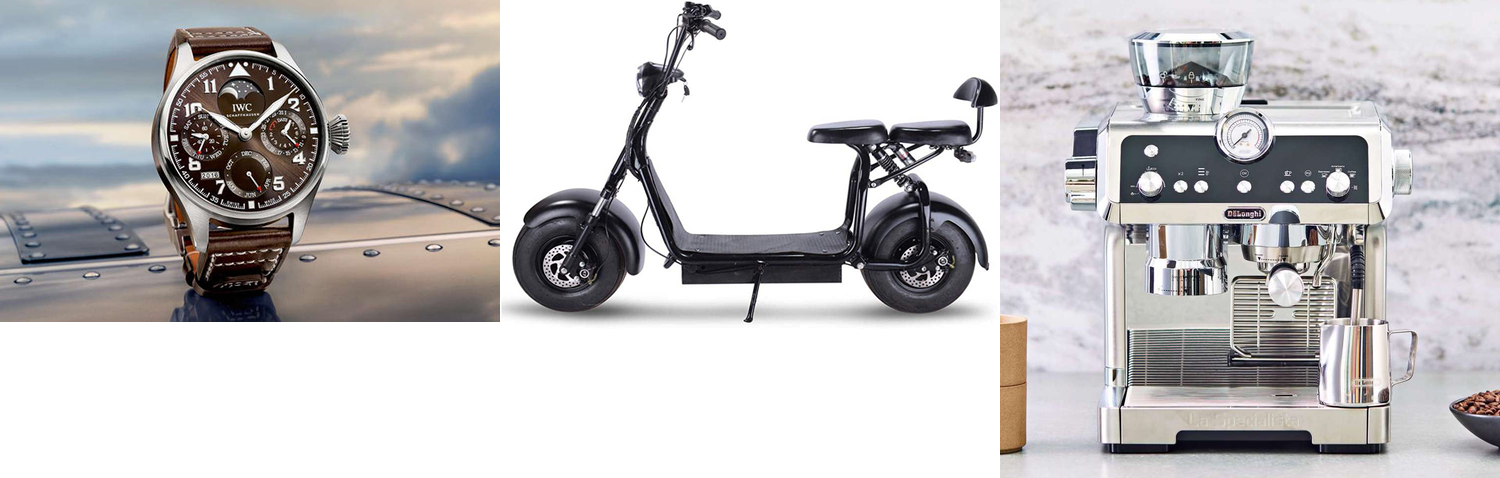

In [44]:
# Display uploaded images

image_files = os.listdir(image_dir)
original_images = []

for file_name in image_files:
    # Skip if the file is not an image
    if not file_name.endswith(('.jpg', '.png')):
        continue

    # Load and resize the image to a desired size (e.g., 500 pixels)
    input_file_path = os.path.join(image_dir, file_name)
    image = resize_image(load_img(input_file_path), 500)

    original_images.append(image)

# Display the original images
display_images(original_images)

In [6]:
'''
Executes the U2-Net algorithm to detect objects in the provided images directory and generate masks.
These masks are used to separate foreground objects from the background.
The resulting masks are then saved in the results directory for further processing.
'''
def run_u2net():
    !python -W ignore u2net_test.py

In [7]:
# Crop and make backgrounds transparent in all images using U2-Net generated masks
def remove_background():

    image_dir = os.path.join(os.getcwd(), 'images')
    results_dir = os.path.join(os.getcwd(), 'results')
    image_files = os.listdir(image_dir)

    threshold = 0.9        # Threshold for background removal
    rescale_factor = 255   # Rescale factor for normalization
    target_layer_index = 2 # Target layer index for bounding box creation

    cropped_images = []    # Initialize the cropped images list

    for file_name in image_files:
        # Skip if the file is not an image
        if not file_name.endswith(('.jpg', '.png')):
            continue

        # Construct the file paths for the input and output images
        input_file_path = os.path.join(image_dir, file_name)
        output_file_path = os.path.join('/content/U-2-Net/results/', file_name[:-4] + '.png')

        # Load the output image from the U-2-Net results directory
        output_img = load_img(output_file_path)

        # Convert the output image to a numpy array and normalize the pixel values
        output_array = img_to_array(output_img) / rescale_factor

        # Apply thresholding to obtain a binary mask
        output_array[output_array > threshold] = 1
        output_array[output_array <= threshold] = 0

        # Create RGBA representation of the output image with transparency
        shape = output_array.shape
        alpha_layer_init = np.ones(shape=(shape[0], shape[1], 1))
        foreground_mask = np.expand_dims(output_array[:, :, 0], axis=2)
        alpha_layer = foreground_mask * alpha_layer_init
        rgba_output = np.append(output_array, alpha_layer, axis=2)

        # Load the input image
        input_img = load_img(input_file_path)
        input_array = img_to_array(input_img) / rescale_factor

        # Create RGBA representation of the input image with transparency
        alpha_layer = np.ones(shape=(shape[0], shape[1], 1))
        rgba_input = np.append(input_array, alpha_layer, axis=2)

        # Remove the background by multiplying the input and output images
        rem_back = rgba_input * rgba_output

        # Scale the pixel values back to the original range
        rem_back_scaled = rem_back * rescale_factor

        # Find the bounding box coordinates based on the specified layer
        target_layer = output_array[:, :, target_layer_index]
        x_starts = [np.where(row == 1)[0][0] if np.any(row == 1) else output_array.shape[1] + 1 for row in target_layer]
        x_ends = [np.where(row == 1)[0][-1] if np.any(row == 1) else 0 for row in target_layer]
        y_starts = [np.where(column == 1)[0][0] if np.any(column == 1) else output_array.shape[0] + 1 for column in target_layer.T]
        y_ends = [np.where(column == 1)[0][-1] if np.any(column == 1) else 0 for column in target_layer.T]

        # Calculate the bounding box coordinates
        start_x = min(x_starts)
        end_x = max(x_ends)
        start_y = min(y_starts)
        end_y = max(y_ends)

        # Crop the image based on the bounding box coordinates
        cropped_image = rem_back_scaled[start_y:end_y, start_x:end_x, :]

        # Store the cropped images
        cropped_images.append(Img.fromarray(cropped_image.astype('uint8'), 'RGBA'))

    return cropped_images


In [8]:
# Create masks for cropped images
def generate_masks(images):

    masks = []
    for image in images:
        # Extract the alpha channel
        alpha_channel = image.split()[3]

        # Threshold the alpha channel
        mask = alpha_channel.point(lambda p: 0 if p > 128 else 255)
        masks.append(mask)

    return masks


# Thicken the boundaries of the masks
def dilate_masks(masks, size=10):

    dilated_masks = []
    for mask in masks:
        mask_array = np.array(mask)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

        # Use erosion instead of dilation since the mask is black (normally white)
        eroded_mask = cv2.erode(mask_array, kernel, iterations=1)
        dilated_masks.append(Img.fromarray(eroded_mask))

    return dilated_masks

In [9]:
import torch

def generate_images(pipe, image, mask, prompt, negative_prompt=None, guidance_scale=7.5, num_samples=1, num_inference_steps=10, seed=-1, height=512, width=512):
    """
    Generates images using the Stable Diffusion Inpainting pipeline.

    Args:
        pipe (StableDiffusionInpaintPipeline): The pipeline for image generation.
        image (PIL.Image): The input image.
        mask (PIL.Image): The mask image.
        prompt (str): The prompt text for generating images.
        guidance_scale (float, optional): The scale factor for guidance loss. Default is 7.5.
        num_samples (int, optional): The number of generated images per prompt. Default is 1.
        num_inference_steps (int, optional): The number of inference steps for generation. Default is 10.
        seed (int, optional): The seed value for random number generation. Default is -1.
        height (int, optional): The height of the generated images. Default is 512.
        width (int, optional): The width of the generated images. Default is 512.

    Returns:
        List[PIL.Image]: The generated images.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = torch.Generator(device=device).manual_seed(seed)

    images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=image,
        mask_image=mask,
        guidance_scale=guidance_scale,
        generator=generator,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        height=height,
        width=width,
    ).images

    return images


['/content/U-2-Net/images/watch.jpg', '/content/U-2-Net/images/scooter.jpg', '/content/U-2-Net/images/coffee_machine.jpg']
inferencing: watch.jpg
inferencing: scooter.jpg
inferencing: coffee_machine.jpg


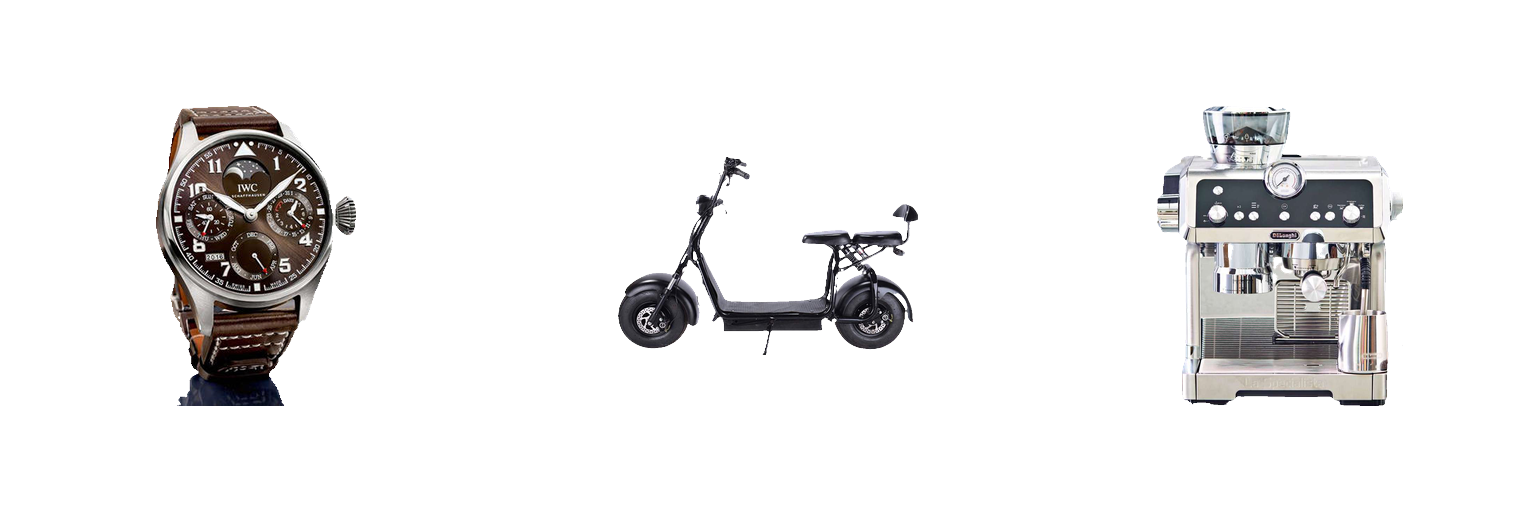

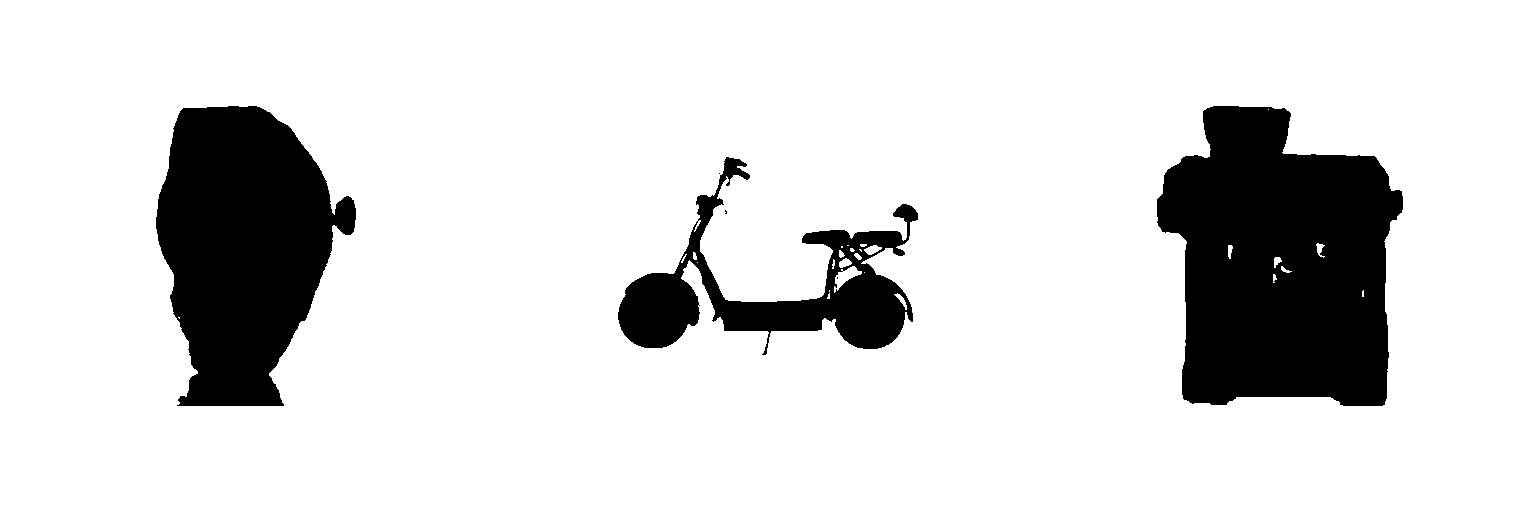

In [37]:
# Remove background of the images and create masks before Stable Diffusion algorithm

run_u2net()
cropped_images = remove_background()

resize_factor = 300
cropped_images = [resize_image(im, resize_factor) for im in cropped_images]
mask_images = generate_masks(cropped_images)

cropped_images = [extend_image(im, 512, 512) for im in cropped_images]
mask_images = [extend_mask(m, 512, 512) for m in mask_images]

display_images(cropped_images)
display_images(mask_images)

  0%|          | 0/20 [00:00<?, ?it/s]

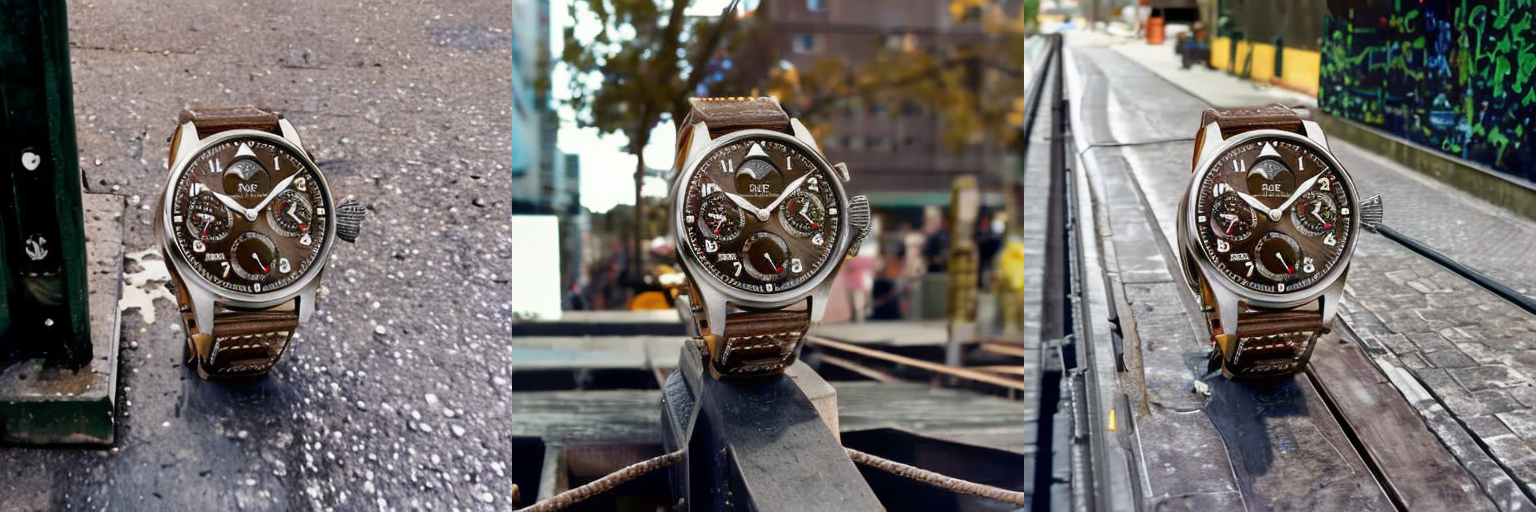

  0%|          | 0/20 [00:00<?, ?it/s]

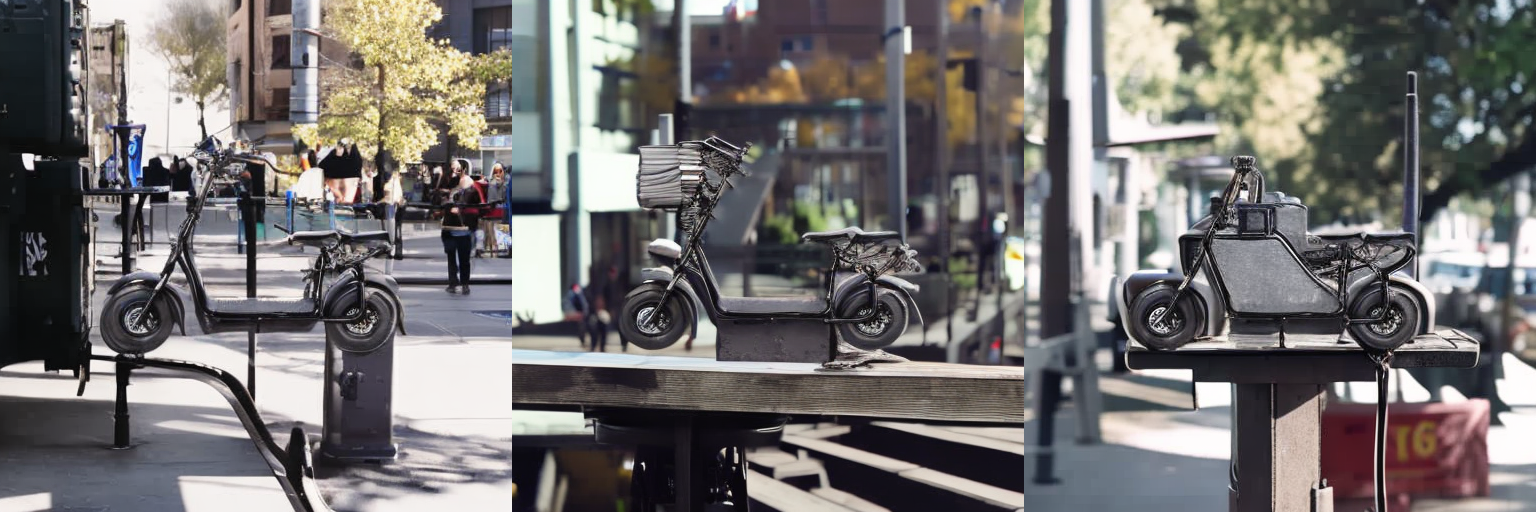

  0%|          | 0/20 [00:00<?, ?it/s]

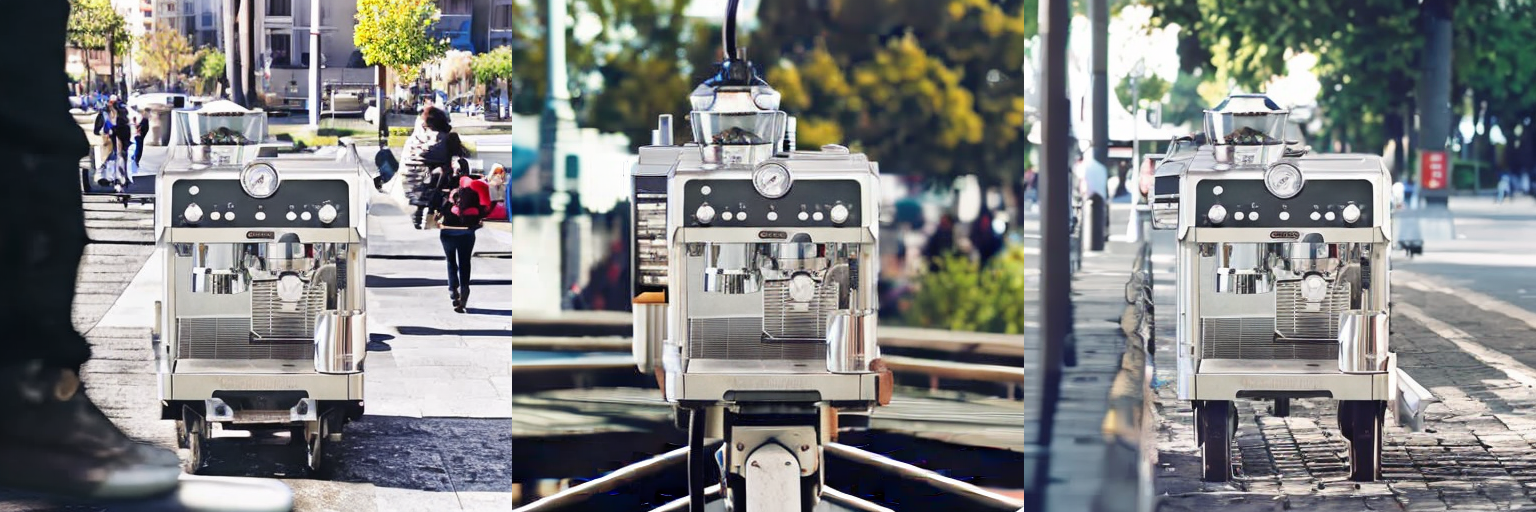

In [43]:
# Run Stable Diffusion Inpainting algorithm

#pipe = diffusion_setup()

seed = 0

for i in range(len(cropped_images)):

    generated_images = generate_images(pipe, cropped_images[i], mask_images[i],
                                       prompt = "object displayed on a platform in a busy urban district, dslr, natural shadow, natural light, sharp, in focus, 4k",
                                       guidance_scale=7.5,
                                       num_samples=3,
                                       num_inference_steps=20,
                                       seed=seed,
                                       height=512,
                                       width=512)

    display_images(generated_images)

    torch.cuda.empty_cache()

In [ ]:
# Web-based interface with Gradio

pipe = diffusion_setup()

def bg_remover(image):
    clear_directory(image_dir)
    clear_directory(results_dir)

    image.save(image_dir + "/image.jpg")

    # Remove background of the images and create masks before Stable Diffusion algorithm
    run_u2net()
    cropped_images = remove_background()

    cropped_images = [resize_image(im, 256) for im in cropped_images]
    mask_images = generate_masks(cropped_images)

    cropped_images = [extend_image(im) for im in cropped_images]
    mask_images = [extend_mask(m) for m in mask_images]

    cropped_image = cropped_images[0]
    mask_image = mask_images[0]

    cropped_image.save("saved/cropped_image.png")
    mask_image.save("saved/mask_image.png")

    return cropped_image

# Define the function for image generation
def bg_generator(prompt, guidance_scale, num_inference_steps, seed):

    image = load_img("saved/cropped_image.png")
    mask = load_img("saved/mask_image.png")

    print('AI generation started')
    generated_images = generate_images(pipe, image, mask,
                                       prompt=prompt,
                                       guidance_scale=guidance_scale,
                                       num_samples=1,
                                       num_inference_steps=num_inference_steps,
                                       height=600,
                                       width=600,
                                       seed=seed)
    print('AI generation done')
    generated_images[0].save("saved/generated_image.png")
    return generated_images[0]


with gr.Blocks() as demo:
    description = """
    ## Image Background Removal and Generation

    This application allows you to remove the background of an image and generate a new background using a prompt.
    """
    gr.Markdown(description)
    with gr.Tab("Remove Background"):
        with gr.Row():
            with gr.Column():
                image_input = gr.Image(type="pil", label="Upload an image")
                image_button = gr.Button("Go!")
            image_cropped = gr.Image(type="pil", label="New image")
    with gr.Tab("Generate Background"):
        with gr.Row():
            with gr.Column():
                text_prompt = gr.Textbox(label="AI Prompt")
                slider_guidance = gr.inputs.Slider(minimum=1, maximum=15, default=7.5, label="Guidance Scale")
                slider_inference = gr.inputs.Slider(minimum=5, maximum=25, default=15, step=1, label="Inference Steps")
                slider_seed = gr.inputs.Slider(minimum=1, maximum=100, default=1, step=1, label="Seed")
                text_button = gr.Button("Generate!")
                gr.Markdown("When there's no GPU available, each iteration can take up to 50 seconds.")
            image_generated = gr.Image(type="pil", label="AI generated image")

    image_button.click(bg_remover, inputs=image_input, outputs=image_cropped)
    text_button.click(bg_generator, inputs=[text_prompt, slider_guidance, slider_inference, slider_seed], outputs=image_generated)

demo.queue()
demo.launch(share=True, debug=True)


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:89: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:93: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://aa4f674c811dca6aec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


['/content/U-2-Net/images/image.jpg']
inferencing: image.jpg
AI generation started


  0%|          | 0/15 [00:00<?, ?it/s]

AI generation done
AI generation done
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7870 <> https://d1e39aecbdef60cea7.gradio.live
Killing tunnel 127.0.0.1:7870 <> https://aa4f674c811dca6aec.gradio.live
